### Load dan EDA Dasar

In [30]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/raw/tokopedia_reviews.csv")
print(f"Dataset shape: {df.shape}")
df.head()

Dataset shape: (612, 2)


,review,rating
0,Beli starlight tp katane habis dikirim warna h...,1
1,"Dapat barang minus di layar, seperti ada kilat...",1
2,Kondisi segel nya udah kebuka gatau ini ori ap...,1
3,"saya udh nunggu garansi IBOX 1bulanan, hpnya g...",1
4,Saya beli barangnya hilang di pengiriman (Ante...,1


### Basic Info & Missing Values

In [31]:
print("=== Dataset Info ===")
df.info()

print("\n=== Missing Values ===")
print(df.isnull().sum())

print("\n=== Duplicate Rows ===")
print(f"Duplicates: {df.duplicated().sum()}")

print("\n=== Rating Distribution ===")
print(df['rating'].value_counts().sort_index())

=== Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   review  612 non-null    object
 1   rating  612 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 9.7+ KB

=== Missing Values ===
review    0
rating    0
dtype: int64

=== Duplicate Rows ===
Duplicates: 0

=== Rating Distribution ===
rating
1     24
2      5
3     19
4     66
5    498
Name: count, dtype: int64


### Cleaning

In [32]:
# Remove duplicates
df = df.drop_duplicates()

# Remove rows with missing reviews
df = df.dropna(subset=["review"])

# Remove very short reviews (less than 5 characters)
df = df[df["review"].str.len() >= 5]

# Clean rating column
df = df.dropna(subset=["rating"])
df["rating"] = df["rating"].astype(int)

print(f"Dataset shape after cleaning: {df.shape}")

Dataset shape after cleaning: (607, 2)


### Labeling

In [33]:
def label_sentiment(rating):
    if rating <= 2:
        return "negative"
    elif rating == 3:
        return "neutral"
    else:
        return "positive"

df["sentiment"] = df["rating"].apply(label_sentiment)

print("=== Sentiment Distribution ===")
print(df["sentiment"].value_counts())
print("\n=== Sentiment Proportion ===")
print(df["sentiment"]. value_counts(normalize=True))

=== Sentiment Distribution ===
sentiment
positive    560
negative     29
neutral      18
Name: count, dtype: int64

=== Sentiment Proportion ===
sentiment
positive    0.922570
negative    0.047776
neutral     0.029654
Name: proportion, dtype: float64


### Text Processing with Stemming

In [34]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

stop_words = set(stopwords.words("indonesian"))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r"http\S+", "", text)
    
    # Remove numbers and special characters
    text = re.sub(r"[^a-z\s]", "", text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords, short words, and apply stemming
    tokens = [
        stemmer.stem(w) 
        for w in tokens 
        if w not in stop_words and len(w) > 2
    ]
    
    return " ".join(tokens)

# Apply preprocessing
df["clean_text"] = df["review"].apply(preprocess_text)

print("=== Sample Before and After Preprocessing ===")
sample_df = df[["review", "clean_text"]].head(3)
for idx, row in sample_df.iterrows():
    print(f"\nOriginal: {row['review']}")
    print(f"Cleaned:   {row['clean_text']}")

=== Sample Before and After Preprocessing ===

Original: Beli starlight tp katane habis dikirim warna hitam
Harusnya barang barang NEW tapi garansi sudah di aktifkan tanggal 25 Mei seller sudah dichat via wa tp ga di bls..
saya cuma mau konfirmasi nya
padahal tanggal 9 juli
hadeh ga koperatif banget
Cleaned:   beli starlight katane habis kirim warna hitam barang barang new garansi aktif tanggal mei seller dichat via bls konfirmasi nya tanggal juli hadeh koperatif banget

Original: Dapat barang minus di layar, seperti ada kilatan saat awal buka kunci, pas pengajuan komplain seller malah bilang kalau barang sudah sampai, padahal komplain saya soal barang yg cacat.!!!
Cleaned:   barang minus layar kilat buka kunci pas aju komplain seller bilang barang komplain barang cacat

Original: Kondisi segel nya udah kebuka gatau ini ori apa bukan yg jelas bkn new lg
Cleaned:   kondisi segel nya udah buka gatau ori bkn new


### Exploratory Data Analysis

In [35]:
# Review length analysis
df["review_length"] = df["clean_text"].apply(len)

print("=== Review Length Statistics ===")
print(df["review_length"].describe())

print("\n=== Review Length by Sentiment ===")
print(df.groupby("sentiment")["review_length"].describe())

=== Review Length Statistics ===
count    607.000000
mean      84.108731
std       66.834938
min        5.000000
25%       44.000000
50%       66.000000
75%      102.000000
max      609.000000
Name: review_length, dtype: float64

=== Review Length by Sentiment ===
           count        mean         std  min   25%   50%     75%    max
sentiment                                                               
negative    29.0  126.310345  147.325951  5.0  45.0  87.0  134.00  609.0
neutral     18.0   84.833333   70.157176  6.0  32.0  56.5  129.75  232.0
positive   560.0   81.900000   59.230975  6.0  45.0  66.0  100.25  456.0


<Figure size 1000x600 with 0 Axes>

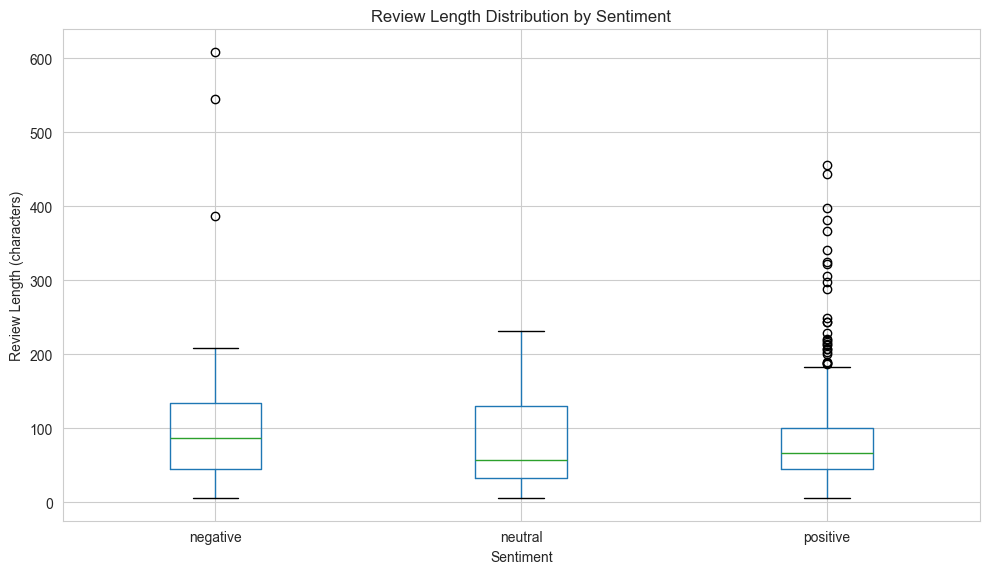

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(10, 6))

df.boxplot(column="review_length", by="sentiment", figsize=(10,6))
plt.title("Review Length Distribution by Sentiment")
plt.suptitle("")
plt.ylabel("Review Length (characters)")
plt.xlabel("Sentiment")
plt.tight_layout()
plt.show()

### Word Frequency Analysis

In [37]:
from collections import Counter

def tokenize(text):
    return text.split()

positive_words = Counter()
negative_words = Counter()
neutral_words = Counter()

for _, row in df.iterrows():
    words = tokenize(row["clean_text"])
    if row["sentiment"] == "positive":
        positive_words.update(words)
    elif row["sentiment"] == "negative":
        negative_words.update(words)
    elif row["sentiment"] == "neutral":
        neutral_words.update(words)

print("=== Top 10 Positive Words ===")
print(positive_words.most_common(10))

print("\n=== Top 10 Negative Words ===")
print(negative_words.most_common(10))

print("\n=== Top 10 Neutral Words ===")
print(neutral_words.most_common(10))

=== Top 10 Positive Words ===
[('barang', 364), ('kirim', 218), ('aman', 185), ('garansi', 159), ('cepat', 139), ('segel', 122), ('seller', 119), ('sesuai', 116), ('original', 110), ('resmi', 98)]

=== Top 10 Negative Words ===
[('kirim', 17), ('barang', 17), ('beli', 12), ('toko', 11), ('ngga', 10), ('nya', 9), ('udah', 7), ('minggu', 7), ('harga', 7), ('layan', 7)]

=== Top 10 Neutral Words ===
[('kirim', 11), ('barang', 9), ('paa', 6), ('aman', 4), ('banget', 4), ('garansi', 4), ('kasih', 4), ('saa', 4), ('dus', 3), ('kode', 3)]


### Word Cloud Visualization

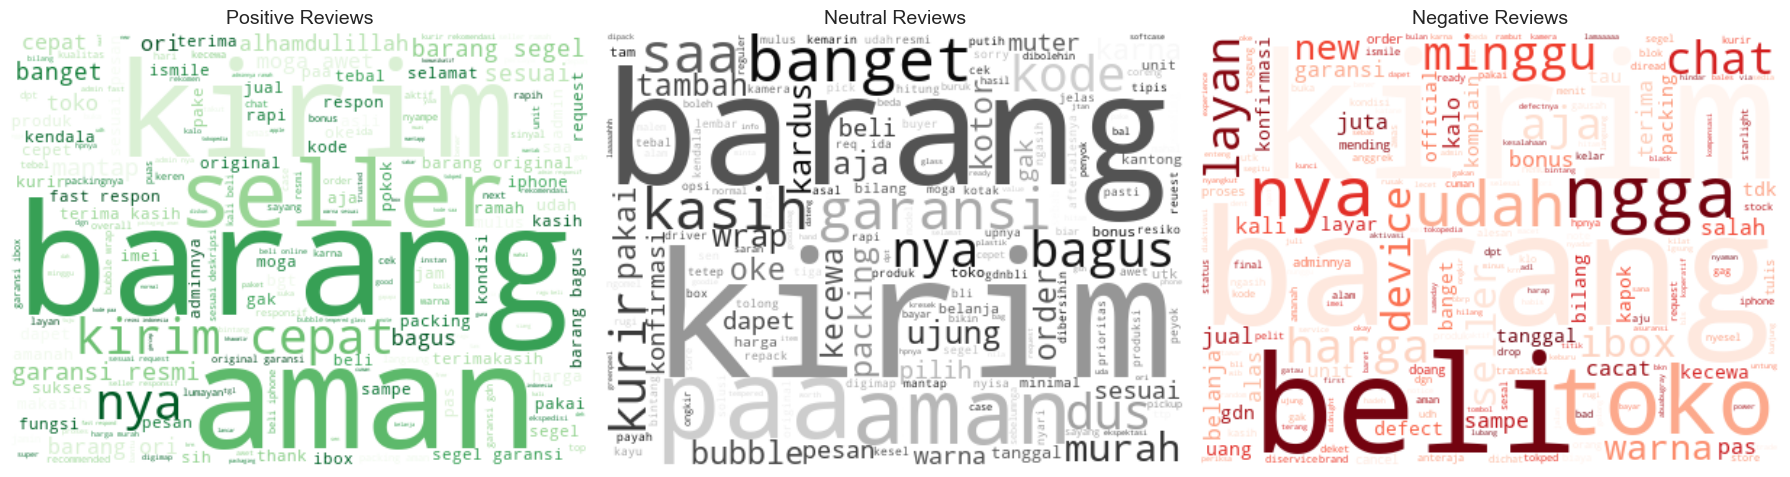

In [38]:
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sentiments = ['positive', 'neutral', 'negative']
colors = ['Greens', 'gray', 'Reds']

for idx, sentiment in enumerate(sentiments):
    text = ' '.join(df[df['sentiment'] == sentiment]['clean_text'])
    wordcloud = WordCloud(
        width=400, 
        height=300, 
        background_color='white',
        colormap=colors[idx]
    ).generate(text)
    
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{sentiment.capitalize()} Reviews', fontsize=14)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Save Cleaned Dataset

In [39]:
df_final = df[["review", "clean_text", "rating", "sentiment"]]
df_final.to_csv("../data/processed/tokopedia_reviews_clean.csv", index=False)

print("Cleaned dataset saved to:  ../data/processed/tokopedia_reviews_clean.csv")
print(f"\nFinal dataset shape: {df_final.shape}")
print("\nFinal sentiment distribution:")
print(df_final['sentiment'].value_counts())

Cleaned dataset saved to:  ../data/processed/tokopedia_reviews_clean.csv

Final dataset shape: (607, 4)

Final sentiment distribution:
sentiment
positive    560
negative     29
neutral      18
Name: count, dtype: int64
